<a href="https://colab.research.google.com/github/LinCheungS/TensorFlow2_DL/blob/master/tf_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tf.estimator

In [0]:
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time

## 清洗可视化

In [0]:
row_data = pd.read_csv("aa.csv")
y_row_data= row_data.pop("Survived")
train_df, eval_df, y_train, y_eval = train_test_split(row_data, y_row_data)
train_df = pd.DataFrame(train_df)
eval_df = pd.DataFrame(eval_df)
y_train = pd.DataFrame(y_train)
y_eval = pd.DataFrame(y_eval)
print(train_df.shape,eval_df.shape,y_train.shape,y_eval.shape)

(666, 8) (223, 8) (666, 1) (223, 1)


In [0]:
train_df.head(3)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
481,3,male,50.0,0,0,A/5 3594,8.05,S
558,3,female,36.0,1,0,345572,17.40,S
817,3,male,43.0,0,0,C 7075,6.45,S


In [0]:
train_df.describe()

,Pclass,Age,SibSp,Parch,Fare
count,666.000000,666.000000,666.000000,666.000000,666.000000
mean,2.328829,29.878164,0.515015,0.372372,31.088343
std,0.830786,12.834671,1.077696,0.800049,47.638719
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.895800
50%,3.000000,30.000000,0.000000,0.000000,14.454200
75%,3.000000,35.000000,1.000000,0.000000,30.646850
max,3.000000,71.000000,8.000000,6.000000,512.329200


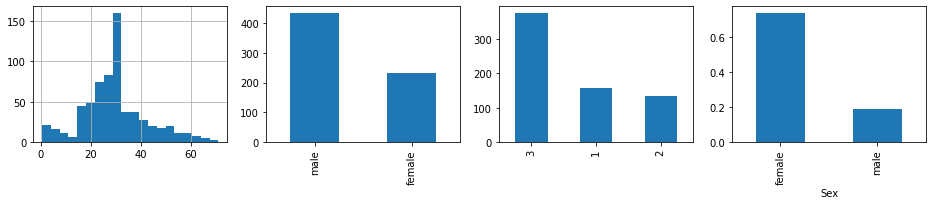

In [0]:
# 年龄的分布图
fig = plt.figure(figsize=[16,2.5])
plt.subplot(141)
train_df["Age"].hist(bins = 20)
# 性别的分别
plt.subplot(142)
train_df["Sex"].value_counts().plot(kind='bar')
# pclass的分别
plt.subplot(143)
train_df["Pclass"].value_counts().plot(kind='bar')
# 对于女性多少百分比获救,对于男性多少百分比
plt.subplot(144)
pd.concat([row_data, y_row_data], axis = 1).groupby("Sex").Survived.mean().plot(kind='bar')

## feature_column

特征列 通常用于对结构化数据实施特征工程时候使用, 使用特征列可以将类别特征转换为one-hot编码特征，将连续特征构建分桶特征.

In [0]:
# 数值数据,分类数据
categorical_columns = ['Pclass', 'Sex', 'SibSp','Parch', 'Ticket','Embarked']
numeric_columns = ['Age', 'Fare']
feature_columns = []
# 将categorical特征,封装成feature_columns
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique() # 生成所有的可能的数据
    feature_columns.append(                    # 添加到feature_columns中
        tf.feature_column.indicator_column(    # 生成onehot编码
            tf.feature_column.categorical_column_with_vocabulary_list(  # 生成categorical_feature_column
                categorical_column, vocab)))
# 将numeric特征封装成feature_columns
for numeric_column in numeric_columns:
    feature_columns.append(       # 添加到feature_columns中
        tf.feature_column.numeric_column(     # 生成numeric_feature_column
            numeric_column, dtype=tf.float32))

print(feature_columns)

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(1, 3, 2), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='SibSp', vocabulary_list=(0, 1, 2, 8, 4, 3, 5), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Parch', vocabulary_list=(0, 5, 3, 1, 2, 4, 6), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='Ticket', vocabulary_list=('5727', '11967', '2672', '113794', '330923', '350048', '113789', '382652', '371060', '2666', 'C.A. 33112', 'A/5 21171', '17421', '2668', 'PC 17604', '349236', '113806', 'A/5 21172', 'STON/O 2. 3101275', '349253', '113050

In [0]:
# 构建数据集
def make_dataset(features, labels, batch_size = 32,training=True):
    # 将dataframe构建成字典, 符合tensor_slices的调用, 将输入转换为数据集
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # 如果在训练模式下混淆并重复数据。
    if training:
        dataset = dataset.shuffle(1000).repeat()
    # 传回一个batch
    return dataset.batch(batch_size)

In [0]:
train_dataset = make_dataset(train_df, y_train, batch_size = 3)
for x, y in train_dataset.take(1):
    print(x)
    print(y)

{'Pclass': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 3, 3])>, 'Sex': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'male', b'male', b'female'], dtype=object)>, 'Age': <tf.Tensor: shape=(3,), dtype=float64, numpy=array([34., 41.,  5.])>, 'SibSp': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 4])>, 'Parch': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 0, 2])>, 'Ticket': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'347080', b'350026', b'347077'], dtype=object)>, 'Fare': <tf.Tensor: shape=(3,), dtype=float64, numpy=array([14.4   , 14.1083, 31.3875])>, 'Embarked': <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'S', b'S', b'S'], dtype=object)>}
tf.Tensor(
[[0]
 [0]
 [1]], shape=(3, 1), dtype=int64)


In [0]:
# 将feature_column转成keras.layers.DenseFeature,以便喂给dataset
for x, y in train_dataset.take(1):
    gender_column = feature_columns[1]
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())
    print("可视化sex")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[47.        1.        0.       ...  0.        0.        0.      ]
 [30.626179  1.        0.       ...  0.        0.        0.      ]
 [15.        0.        0.       ...  0.        0.        0.      ]]
可视化sex


## premade estimator

In [0]:
# 构建数据集
def make_dataset(features, labels, batch_size = 32,training=True):
    # 将dataframe构建成字典, 符合tensor_slices的调用, 将输入转换为数据集
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # 如果在训练模式下混淆并重复数据。
    if training:
        dataset = dataset.shuffle(1000).repeat()
    # 传回一个batch
    return dataset.batch(batch_size)

### BaselineClassifier

In [0]:
baseline_estimator = tf.estimator.BaselineClassifier(n_classes = 2)
baseline_estimator.train(input_fn = lambda : make_dataset(train_df, y_train))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpvak8c9i9', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


FailedPreconditionError: ignored

In [98]:
baseline_estimator = tf.compat.v1.estimator.BaselineClassifier(n_classes = 2)
baseline_estimator.train(input_fn = lambda : make_dataset(train_df, y_train), steps = 2000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmes_cq3v', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.


In [99]:
eval_result = baseline_estimator.evaluate(
    input_fn=lambda: make_dataset(eval_df, y_eval, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-05-07T15:42:52Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmes_cq3v/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.42588s
INFO:tensorflow:Finished evaluation at 2020-05-07-15:42:53
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.6143498, accuracy_baseline = 0.6143498, auc = 0.5, auc_precision_recall = 0.6928251, average_loss = 0.66681707, global_step = 2000, label/mean = 0.38565022, loss = 21.242887, precision = 0.0, prediction/mean = 0.38057587, recall = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpmes_cq3v/model.ckpt-2000

Test set accuracy:

### estimator.DNNClassifier

In [100]:
# 构建一个拥有两个隐层，隐藏节点分别为 30 和 10 的深度神经网络。
classifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    # 隐层所含结点数量分别为 30 和 10.
    hidden_units=[100, 50, 10],
    activation_fn = tf.nn.relu,
    optimizer = 'Adam',
    # 模型必须从三个类别中做出选择。
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphfl7az1e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [101]:
# 训练模型。
classifier.train(
    input_fn = lambda : make_dataset(train_df, y_train),
    steps=2000)

# INFO:tensorflow:Loss for final step: 0.50398713.

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmphfl7az1e/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.60879177, step = 0
INF

In [102]:
eval_result = classifier.evaluate(
    input_fn=lambda: make_dataset(eval_df, y_eval, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-05-07T15:44:24Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphfl7az1e/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.60185s
INFO:tensorflow:Finished evaluation at 2020-05-07-15:44:25
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.7892377, accurac

In [0]:
# 只输入x
def input_fn(features, batch_size=32):
    """An input function for prediction."""
    # 将输入转换为无标签数据集。
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

predict_x = eval_df[:3]
# predictions是一个生成器
predictions = classifier.predict(input_fn=lambda: input_fn(predict_x))

In [104]:
expected = ["没生还","生还"]
for pred in predictions:
    class_id = pred['class_ids'][0]
    probability = pred['probabilities'][class_id]
    print("准确率:",probability,expected[class_id])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphfl7az1e/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
准确率: 0.9958247 生还
准确率: 0.97009605 没生还
准确率: 0.8441325 生还


### LinearClassifier

In [0]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(input_fn = lambda : make_dataset(train_df, y_train),steps=2000)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp5_c6pugj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. 

In [0]:
eval_result = linear_est.evaluate(
    input_fn=lambda: make_dataset(eval_df, y_eval, training=False))
print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-05-07T14:57:41Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5_c6pugj/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.58184s
INFO:tensorflow:Finished evaluation at 2020-05-07-14:57:41
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.8206278, accurac

In [0]:
# 只输入x
def input_fn(features, batch_size=32):
    """An input function for prediction."""
    # 将输入转换为无标签数据集。
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

predict_x = eval_df[:3]
# predictions是一个生成器
predictions = linear_est.predict(input_fn=lambda: input_fn(predict_x))

In [0]:
expected = ["没生还","生还"]
for pred in predictions:
    class_id = pred['class_ids'][0]
    probability = pred['probabilities'][class_id]
    print("准确率:",probability,expected[class_id])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp5_c6pugj/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
准确率: 0.83759606 没生还
准确率: 0.92330354 没生还
准确率: 0.9305453 没生还


## model_to_estimator(有问题)

In [0]:
tf.keras.backend.clear_session()
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(lr=0.01),
              metrics = ['accuracy'])

In [0]:
# 1. model.fit 
# 2. model -> estimator -> train

train_dataset = make_dataset(train_df, y_train)
eval_dataset = make_dataset(eval_df, y_eval)

history = model.fit(train_dataset,
                    steps_per_epoch = 20,
                    validation_steps = 8,
                    validation_data = eval_dataset,
                    epochs = 10)


In [0]:
# 构建数据集
def make_dataset(features =train_df , labels=y_train, batch_size = 1,training=True):
    # 将dataframe构建成字典, 符合tensor_slices的调用, 将输入转换为数据集
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # 如果在训练模式下混淆并重复数据。
    if training:
        dataset = dataset.shuffle(1000)
    # 传回一个batch
    return dataset.batch(batch_size)


In [0]:
np.flatten(keras.layers.DenseFeatures(feature_columns)(i).numpy())

AttributeError: ignored

In [0]:
import tempfile
model_dir = tempfile.mkdtemp()
keras_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model, model_dir=model_dir)

In [0]:
keras_estimator.train(input_fn=make_dataset(), steps=500)
eval_result = keras_estimator.evaluate(input_fn=make_dataset(), steps=10)
print('Eval result: {}'.format(eval_result))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


TypeError: ignored